# Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys
sys.path.append('../')
sys.path.append('../../')
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations,culture as c

import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [2]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1}

In [3]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

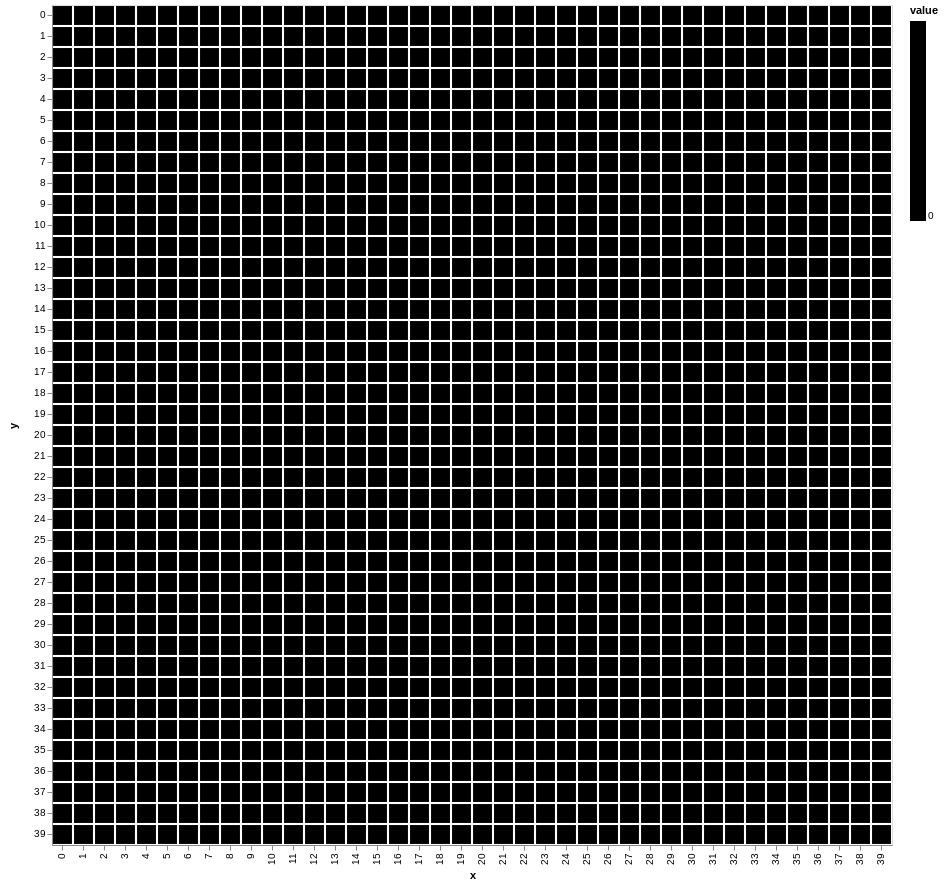

In [4]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated proceduraly. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

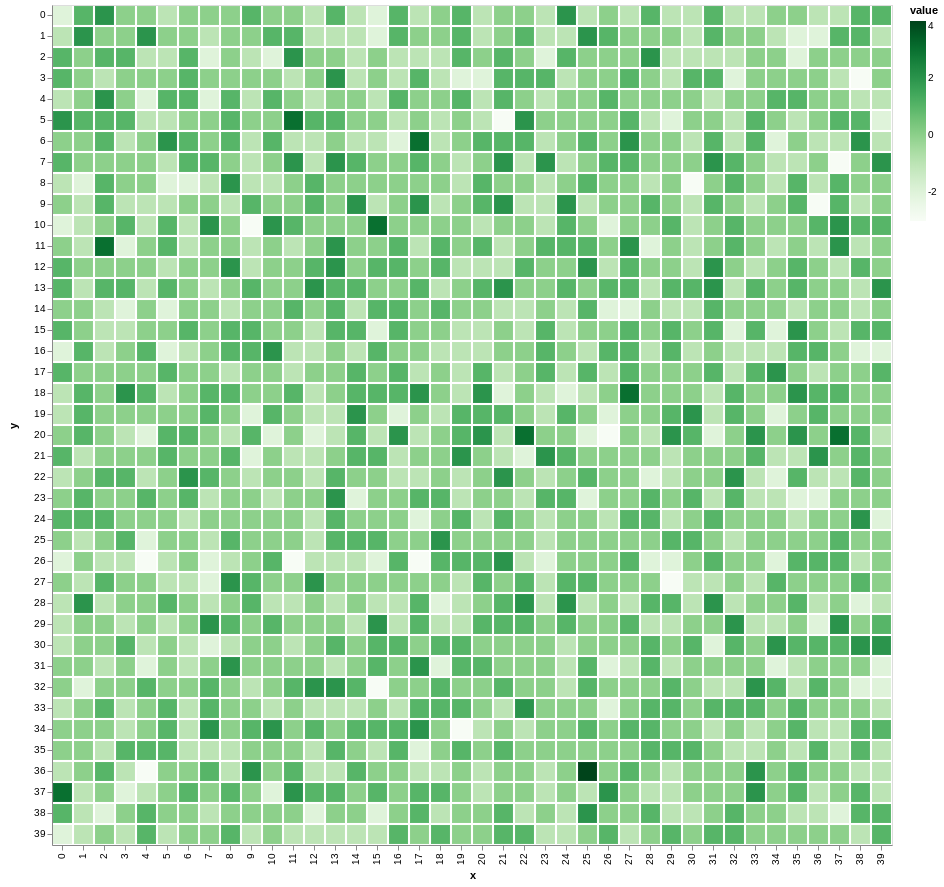

In [5]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [6]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symetrically.

In [7]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [29 38]


,34,35,36,37,38,39,40,41,42
25,1,1,1,1,1,1,1,1,1
26,1,2,2,2,2,2,2,2,1
27,1,2,3,3,3,3,3,2,1
28,1,2,3,4,4,4,3,2,1
29,1,2,3,4,5,4,3,2,1
30,1,2,3,4,4,4,3,2,1
31,1,2,3,3,3,3,3,2,1
32,1,2,2,2,2,2,2,2,1
33,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

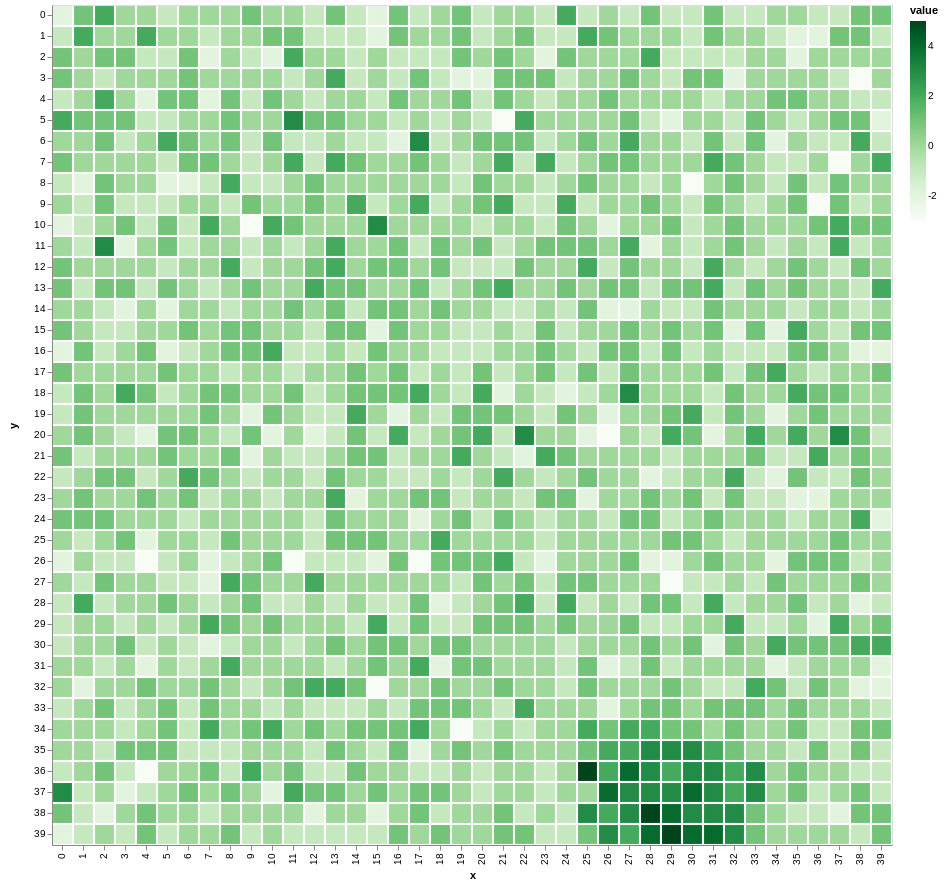

In [8]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board (like Sim City) I'll need to create a brownian motion function to drop a mountain and then move. 

In [9]:
world.brownian_land()

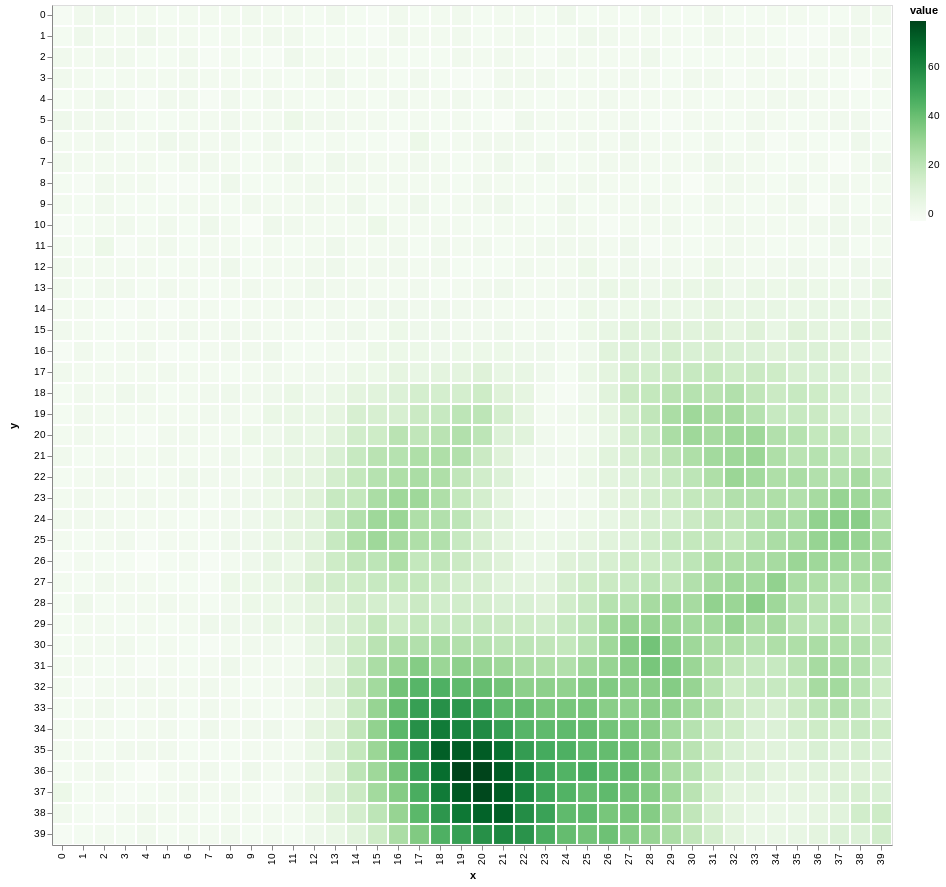

In [10]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `heignt == 0` then you can assume that lower terrain is _under water_

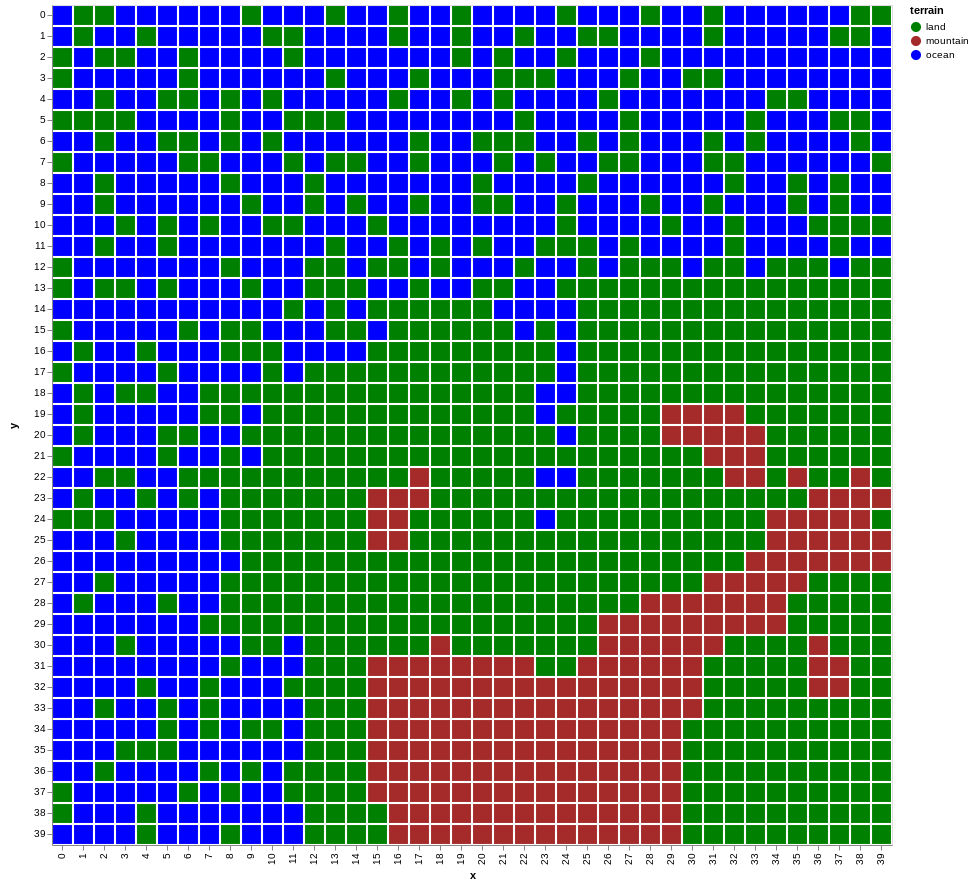

In [11]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forrests. Dry areas become desserts. 

In [12]:
world.brownian_rainfall()

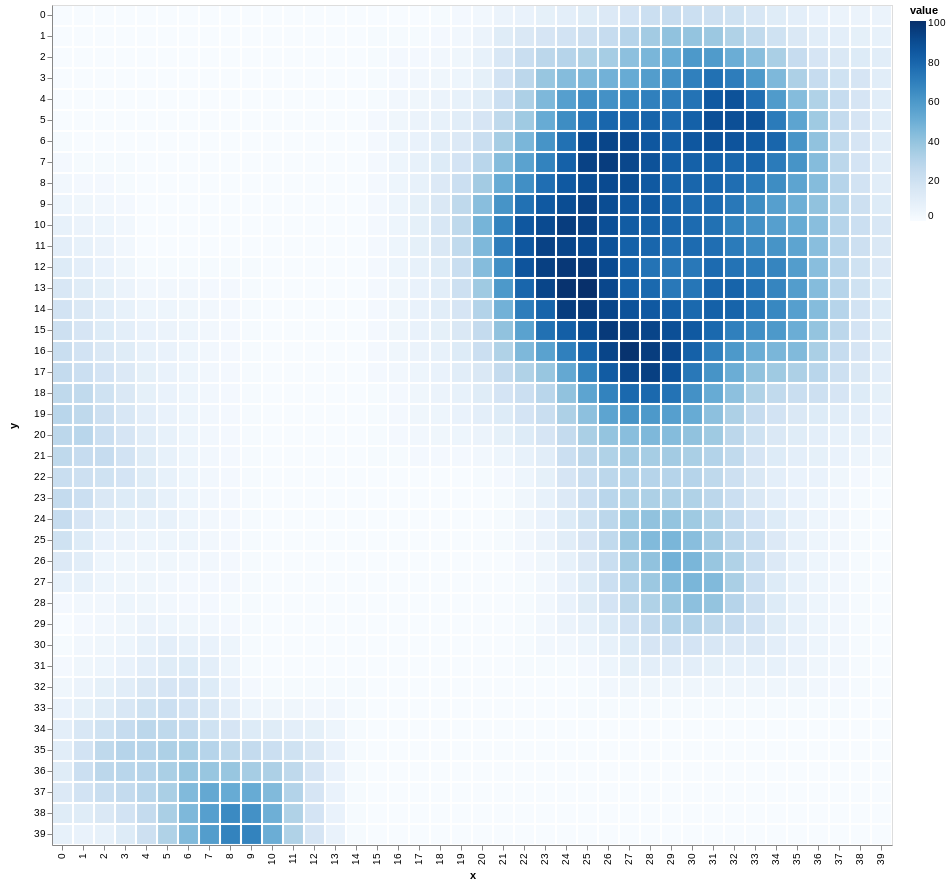

In [13]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [14]:
world.build_df_features()

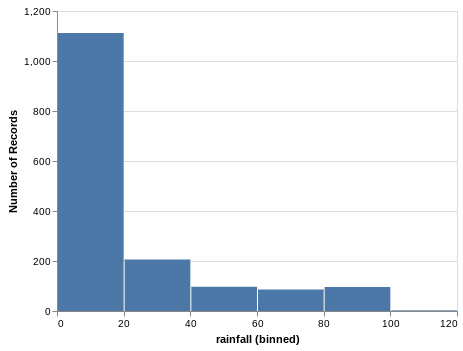

In [15]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

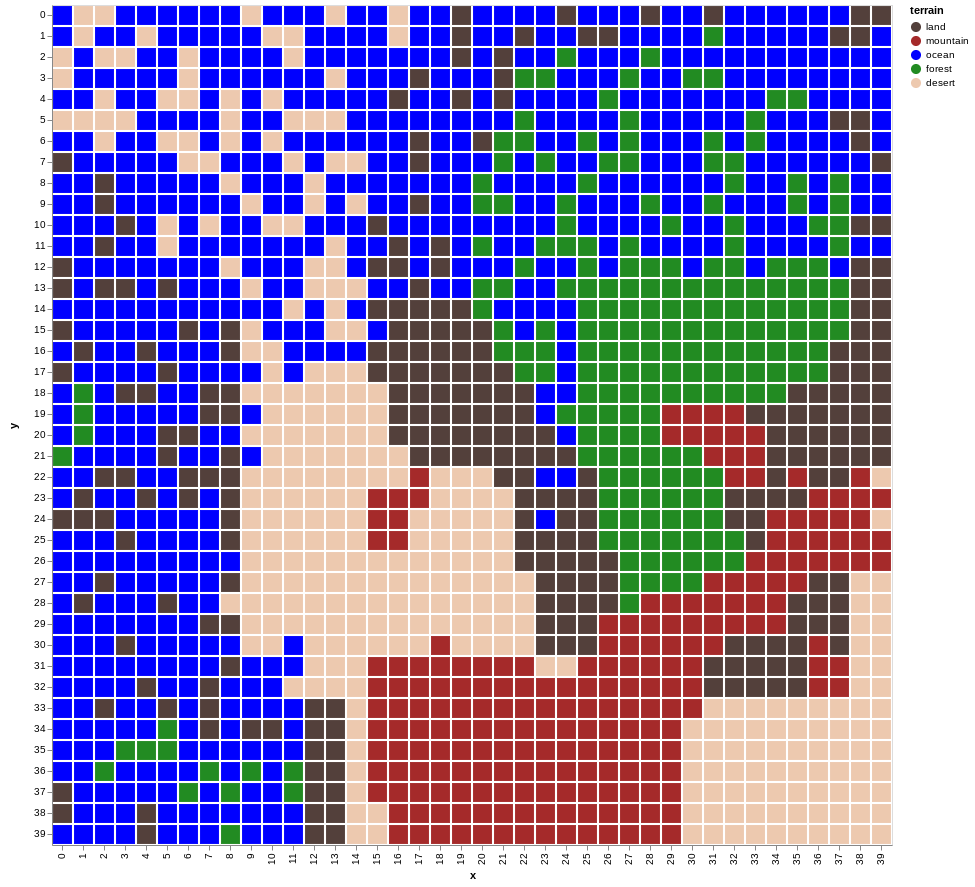

In [16]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the ancients

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes, forrests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 

In [17]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [18]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [19]:
people.Person(world.culture,location=world.get_random_chord())

Fenkunt the peon

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [20]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Buckfellow: population: 1 location: [14,28] founded 1

In [21]:
new_town.speaker

Olfrace the Speaker of Buckfellow

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [22]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Spinhollow: population: 4 location: [16,39] founded 0',
  [Glagsof the Speaker of Spinhollow,
   Zhakellorb the peon,
   Zhacinnale the peon,
   Tralordel the peon]),
 ('town of Rathaven: population: 4 location: [39,34] founded 0',
  [Quaglesh the Speaker of Rathaven,
   Folanden the peon,
   Jadsik the peon,
   Ekohilloh the peon]),
 ('town of Clearcoil: population: 6 location: [17,23] founded 1',
  [Akiwallan the Speaker of Clearcoil,
   Xahalleh the peon,
   Zhallec the peon,
   Alicanab the peon,
   Kraldrundle the peon,
   Tafarrace the peon]),
 ('town of Leafmore: population: 7 location: [26,20] founded 1',
  [Redsath the Speaker of Leafmore,
   Quiwillust the peon,
   Quifillove the peon,
   Logenna the peon,
   Shohan the peon,
   Elixud the peon,
   Toldrich the peon]),
 ('town of Gleamspike: population: 3 location: [18,19] founded 2',
  [Chahnan the Speaker of Gleamspike, Hamsoe the peon, Groscunder the peon]),
 ('town of Stormcoil: population: 4 location: [26,22] 

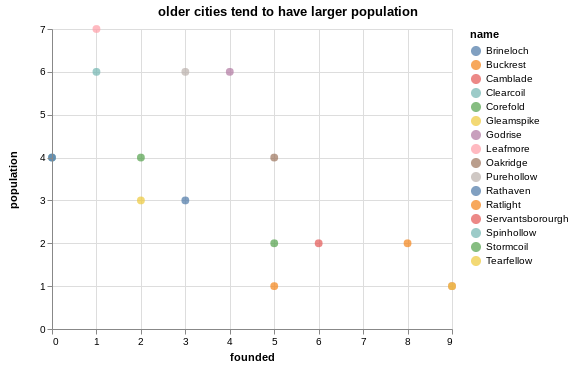

In [23]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

When the character arrives in said town, all of the relevant information will be available in the `get_town_dict` function: 

In [24]:
towns.get_town_dict(world,all_towns[0].name)

{'name': 'Spinhollow',
 'str': 'town of Spinhollow: population: 4 location: [16,39] founded 0',
 'diplomacy': {},
 'nation': 'Spinhollow',
 'type': 'town',
 'population': [{'name': 'Glagsof',
   'role': 'Speaker of Spinhollow',
   'loyalty': 0.5,
   'temperment': 0.8},
  {'name': 'Zhakellorb', 'role': 'peon', 'loyalty': 0.5, 'temperment': 0.09},
  {'name': 'Zhacinnale', 'role': 'peon', 'loyalty': 0.5, 'temperment': 0.41},
  {'name': 'Tralordel', 'role': 'peon', 'loyalty': 0.5, 'temperment': 0.78}]}

This is for rendering `D3.js` templates so it should be an easy to manipulate dict. 

## Adding the towns to the map: 

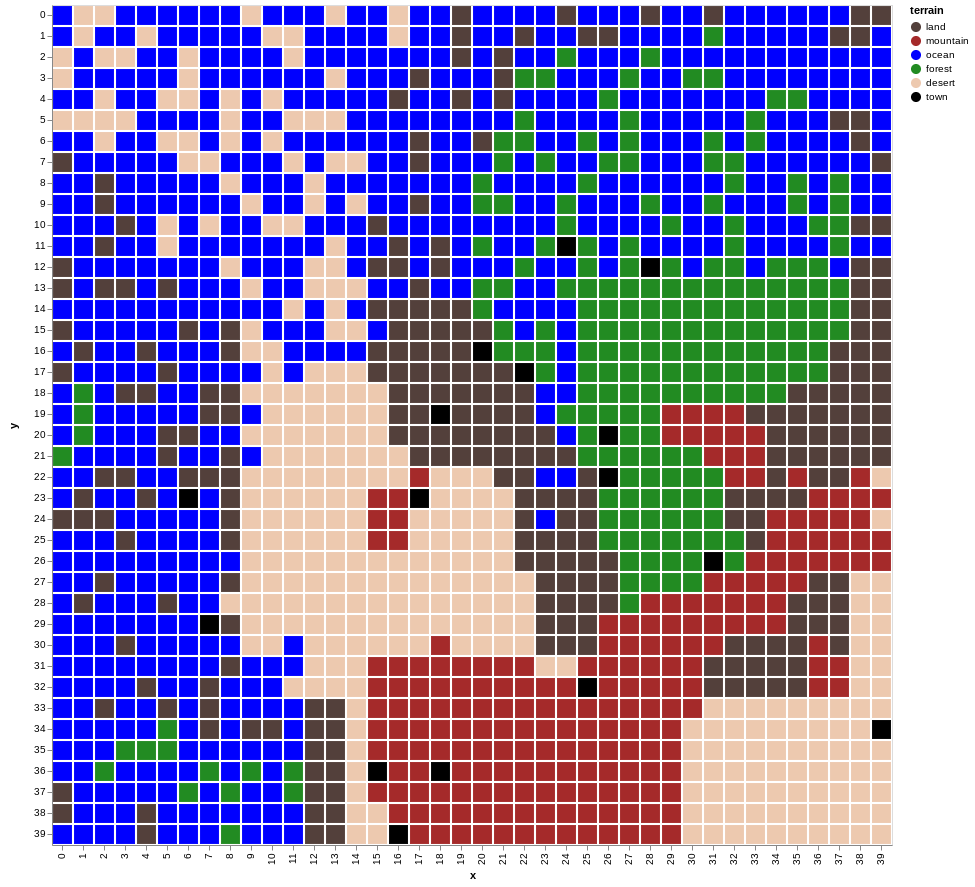

In [25]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

In [26]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
24:11,11,93.0,24,24:11,1.0,town,Brineloch
28:12,12,75.0,28,28:12,1.0,town,Corefold
20:16,16,22.0,20,20:16,3.0,town,Purehollow
22:17,17,32.0,22,22:17,5.0,town,Godrise
18:19,19,5.0,18,18:19,17.0,town,Gleamspike
26:20,20,40.0,26,26:20,5.0,town,Leafmore
26:22,22,28.0,26,26:22,7.0,town,Stormcoil
6:23,23,5.0,6,6:23,1.0,town,Buckrest
17:23,23,0.0,17,17:23,28.0,town,Clearcoil


# Nations

In [27]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Founderstown',
 1: 'Rageridge',
 2: 'Ratglen',
 3: 'Demonsrest',
 4: 'Rockblade',
 5: 'Badgervale',
 6: 'Ravenglen',
 7: 'Splitcrest'}

Standard Scikit-Learn stuffL 

In [28]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,0.0,0,0:0,-2.0,ocean,NaN,NaN,NaN
1:0,0,0.0,1,1:0,1.0,desert,NaN,2.0,Ratglen
2:0,0,0.0,2,2:0,2.0,desert,NaN,2.0,Ratglen
3:0,0,0.0,3,3:0,0.0,ocean,NaN,NaN,NaN
4:0,0,0.0,4,4:0,0.0,ocean,NaN,NaN,NaN
5:0,0,0.0,5,5:0,-1.0,ocean,NaN,NaN,NaN
6:0,0,0.0,6,6:0,0.0,ocean,NaN,NaN,NaN
7:0,0,0.0,7,7:0,0.0,ocean,NaN,NaN,NaN
8:0,0,0.0,8,8:0,0.0,ocean,NaN,NaN,NaN


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [30]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Rathaven is loyal to the nation of Ravenglen
{'nation': 'Ravenglen', 'national fealty': 1}


In [31]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Spinhollow: population: 4 location: [16,39] founded 0,
 capitol of Rathaven: population: 4 location: [39,34] founded 0,
 capitol of Clearcoil: population: 6 location: [17,23] founded 1,
 capitol of Leafmore: population: 7 location: [26,20] founded 1,
 town of Gleamspike: population: 3 location: [18,19] founded 2,
 town of Stormcoil: population: 4 location: [26,22] founded 2,
 capitol of Brineloch: population: 3 location: [24,11] founded 3,
 town of Purehollow: population: 6 location: [20,16] founded 3,
 town of Godrise: population: 6 location: [22,17] founded 4,
 town of Oakridge: population: 4 location: [15,36] founded 5,
 town of Corefold: population: 2 location: [28,12] founded 5,
 town of Buckrest: population: 1 location: [6,23] founded 5,
 town of Camblade: population: 2 location: [18,36] founded 6,
 capitol of Ratlight: population: 2 location: [7,29] founded 8,
 capitol of Servantsborourgh: population: 1 location: [25,32] founded 9,
 capitol of Tearfellow: population:

In [32]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Founderstown,
 Nation of Rageridge,
 Nation of Ratglen,
 Nation of Demonsrest,
 Nation of Rockblade,
 Nation of Badgervale,
 Nation of Ravenglen,
 Nation of Splitcrest]

In [33]:
world.nations[0].towns

[capitol of Tearfellow: population: 1 location: [31,26] founded 9]

In [34]:
world.nations[0].get_capitol().population

[Illialandoch the Speaker of Tearfellow,
 Ekowildim the Ruler of the nation of Founderstown]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nations capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [35]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Illialandoch',
 'role': 'Speaker of Tearfellow',
 'loyalty': 0.5,
 'temperment': 0.81}

In [36]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
24:11,11,93.0,24,24:11,1.0,town,Brineloch,5.0,Badgervale
28:12,12,75.0,28,28:12,1.0,town,Corefold,5.0,Badgervale
6:23,23,5.0,6,6:23,1.0,town,Buckrest,3.0,Demonsrest
7:29,29,3.0,7,7:29,2.0,town,Ratlight,3.0,Demonsrest
31:26,26,39.0,31,31:26,24.0,town,Tearfellow,0.0,Founderstown
15:36,36,0.0,15,15:36,28.0,town,Oakridge,1.0,Rageridge
18:36,36,0.0,18,18:36,68.0,town,Camblade,1.0,Rageridge
16:39,39,0.0,16,16:39,25.0,town,Spinhollow,1.0,Rageridge
20:16,16,22.0,20,20:16,3.0,town,Purehollow,2.0,Ratglen


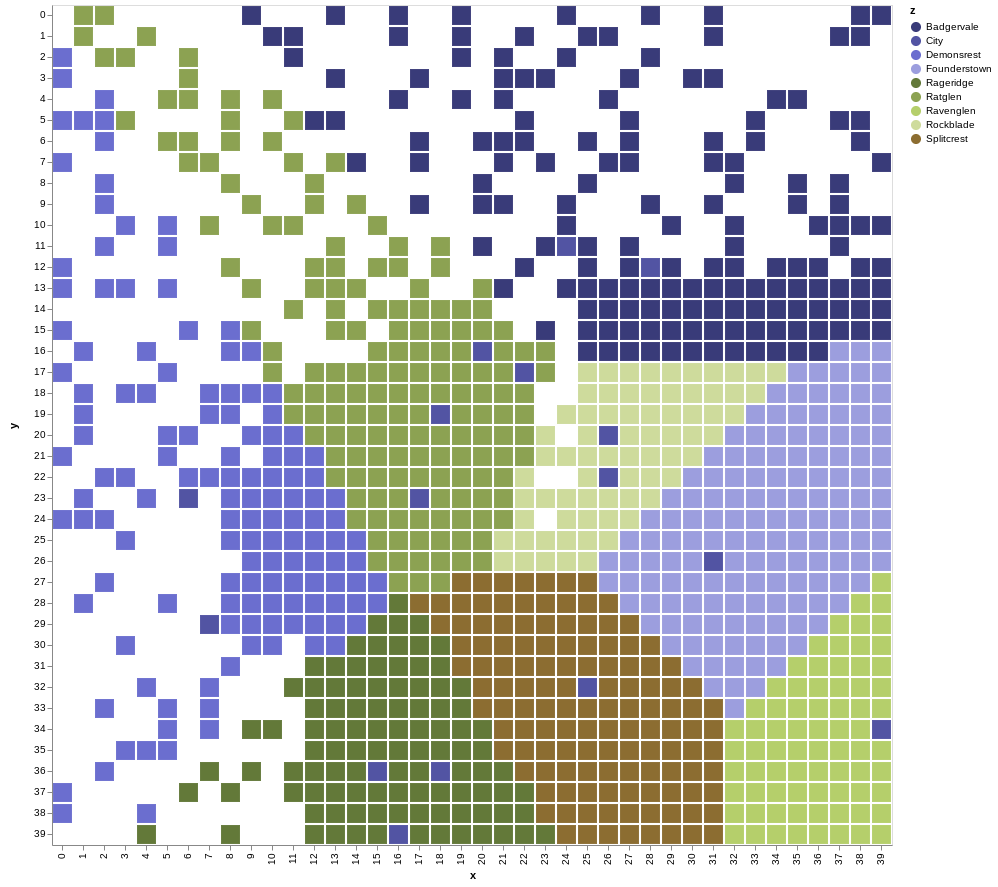

In [37]:
draw.drawboarders(world.df_features)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [38]:
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation,z
key,,,,,,,,,,
0:0,0,0.0,0,0:0,-2.0,ocean,NaN,NaN,NaN,NaN
1:0,0,0.0,1,1:0,1.0,desert,NaN,2.0,Ratglen,Ratglen
2:0,0,0.0,2,2:0,2.0,desert,NaN,2.0,Ratglen,Ratglen
3:0,0,0.0,3,3:0,0.0,ocean,NaN,NaN,NaN,NaN
4:0,0,0.0,4,4:0,0.0,ocean,NaN,NaN,NaN,NaN
5:0,0,0.0,5,5:0,-1.0,ocean,NaN,NaN,NaN,NaN
6:0,0,0.0,6,6:0,0.0,ocean,NaN,NaN,NaN,NaN
7:0,0,0.0,7,7:0,0.0,ocean,NaN,NaN,NaN,NaN
8:0,0,0.0,8,8:0,0.0,ocean,NaN,NaN,NaN,NaN


In [39]:
with open('world_1.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)